### Life Expectancy
Perform regression using this World Health Organization (WHO) dataset on life expectancy.

In [1]:
%reset -f

import pandas as pd
data = pd.read_csv('Life Expectancy Data.csv')
data.head()

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.0               8.16         65.0        0.1  584.259210  33736494.0   
1   58.0               8.18         62.0        0.1  612.696514    327582.0   
2   62.0               8.13         64.0        0.1  631.744976  31731688.0   
3   67.0               8.52         67.0        0.1  669.959000   3696958.0   
4   68.0               7.87         68.0        0.1   63.537231   2978599.0   

    thinness  1-19 years   thinness 5-9 years  \
0                   17.2                 17.3   
1                   17.5                 17.5   
2                   17.7                 17.7   
3                   17.9                 18.0   
4                   18.2                 18.2   

   Income composition of resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5  

[5 rows x 22 columns]

In [2]:
print("Dirty labels:", data.columns)

Dirty labels: Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


In [3]:
# Note that printing data.columns shows that the labels are not properly sanitized (has trailing or leading whitespace, etc.). Let us remove those whitespaces and convert the labels to title case (acronyms and all).

newLabels = []
for label in data.columns:
    if label in {' BMI ', ' HIV/AIDS', 'GDP'}:
        newLabels.append(label.strip())
        continue
    newLabels.append(label.strip().title())
data.columns = newLabels
print("Clean labels:", data.columns)

# We also look at the shape of the dataset.
print("Data shape:", data.shape)

del newLabels

Clean labels: Index(['Country', 'Year', 'Status', 'Life Expectancy', 'Adult Mortality',
       'Infant Deaths', 'Alcohol', 'Percentage Expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'Under-Five Deaths', 'Polio', 'Total Expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'Thinness  1-19 Years',
       'Thinness 5-9 Years', 'Income Composition Of Resources', 'Schooling'],
      dtype='object')
Data shape: (2938, 22)


### Life expectancy age distribution

<AxesSubplot:xlabel='Life Expectancy', ylabel='Count'>

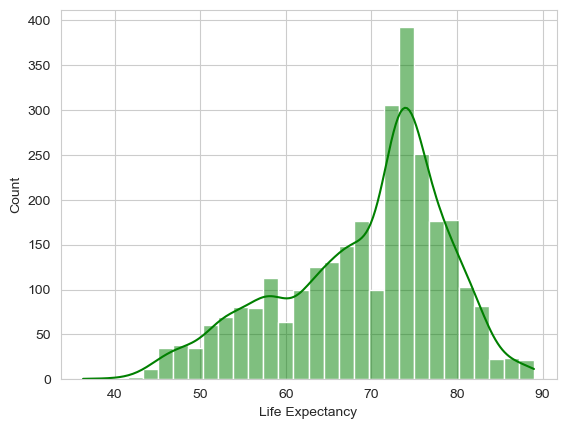

In [4]:
import seaborn as sns
sns.histplot(data['Life Expectancy'].dropna(), kde=True, color='green')

### Data preprocessing
Perform data preprocessing and identify columns to be used. You may or may not use all the columns. Prepare the features and target data.
Prepare the train and test data.

**Quick Notes:** For preprocessing, we've dropped category columns, dropped a feature with no significant relationship with our target vector 'Life Expectancy', performed imputation to estimate nans and fill them up instead of wholesale dropping rows with nans (wasted samples), and then removed outliers. With this, our linear regression model gave us an R2 score of 0.9052645846307381 which I believe is neither too high (low generalizability) nor too low (very poor results). We keep `random_state = 1` for `train_test_split()` all throughout.

We've already performed a little preprocessing in the previous code cells.

Now, our goal is to see if linear regression is appropriate for this dataset, and what features contribute the most information to our model. We must also be aware of *(perfectly) correlated features* which are said to adversely affect the stability and performance of regression methods and thus a few of those must be dropped.

**Sources:**
* [datascience.stackexchange.com](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)
* [cs.princeton.edu](https://www.cs.princeton.edu/courses/archive/fall08/cos436/Duda/PR_lims/cor_feat.htm#:~:text=It%20often%20happens%20that%20two,and%20tend%20to%20vary%20together)

To that end, we generate scatter plots for each feature of the dataset compared against the target vector 'Life expectancy', keeping in mind that we want to find out what features could *reliably* predict Life Expectancy.

**Note:** We immediately drop the *Country* and *Status* columns as these are already informed by the remaining columns and because we want something generalizable to all countries. Moreover, those are highly discrete values (essentially categories). We also immediately drop the *Year* because we want to predict life expectancy not based on explicit time, but based on the current indicators for a country. Ex: if their *GDP* is seen as increasing, then we can predict their life expectancy to also increase. We maintain the other "discrete columns" (for now, like 'Under-Five Deaths') because we know that they aren't exactly "category columns" and they could be reasoned out as estimates (effectively continuous), hence discrete -> continuous works for them.


In [5]:
# TODO: Write your code here. (5 points)
# IDENTIFY COLUMNS TO BE USED
import seaborn as sns

# Preprocessing: Deciding whether to drop or impute null values
print("Number of entries with null values:", data.isna().any(axis=1).sum())     # 1289
print("Number of entries:", data.shape[0])                                      # 2938

# So 44% of the samples would actually be removed if we recklessly drop entries with null values.
# Decision: We apply multivariate imputation to avoid losing too many samples as would have happened with .dropna().

import numpy as np
from sklearn import preprocessing

from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer   # Important!
from sklearn.impute import IterativeImputer     # default imputer is BayesianRidge

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

# Subroutine: Dropping the "category" columns before imputation
data.drop(['Country', 'Status', 'Year'], axis=1, inplace=True)

imp = IterativeImputer(max_iter=10, random_state=1)

data[:] = imp.fit_transform(data)   # one-line fit and transform, plug into data
data.head() # verify that our data frame is still ok

# Source: https://stackoverflow.com/questions/56764044/scikit-problem-returning-dataframe-from-imputer-instead-of-numpy-array
# Source: https://www.youtube.com/watch?v=iQ9oeX-iGeE

Number of entries with null values: 1289
Number of entries: 2938


Life Expectancy  Adult Mortality  Infant Deaths  Alcohol  \
0             65.0            263.0           62.0     0.01   
1             59.9            271.0           64.0     0.01   
2             59.9            268.0           66.0     0.01   
3             59.5            272.0           69.0     0.01   
4             59.2            275.0           71.0     0.01   

   Percentage Expenditure  Hepatitis B  Measles   BMI  Under-Five Deaths  \
0               71.279624         65.0   1154.0  19.1               83.0   
1               73.523582         62.0    492.0  18.6               86.0   
2               73.219243         64.0    430.0  18.1               89.0   
3               78.184215         67.0   2787.0  17.6               93.0   
4                7.097109         68.0   3013.0  17.2               97.0   

   Polio  Total Expenditure  Diphtheria  HIV/AIDS         GDP  Population  \
0    6.0               8.16        65.0       0.1  584.259210  33736494.0   
1   58.0               8.18        62.0       0.1  612.696514    327582.0   
2   62.0               8.13        64.0       0.1  631.744976  31731688.0   
3   67.0               8.52        67.0       0.1  669.959000   3696958.0   
4   68.0               7.87        68.0       0.1   63.537231   2978599.0   

   Thinness  1-19 Years  Thinness 5-9 Years  Income Composition Of Resources  \
0                  17.2                17.3                            0.479   
1                  17.5                17.5                            0.476   
2                  17.7                17.7                            0.470   
3                  17.9                18.0                            0.463   
4                  18.2                18.2                            0.454   

   Schooling  
0       10.1  
1       10.0  
2        9.9  
3        9.8  
4        9.5

In [6]:
print("Number of entries with null values after imputation:", data.isna().any(axis=1).sum())     # 0, good

Number of entries with null values after imputation: 0


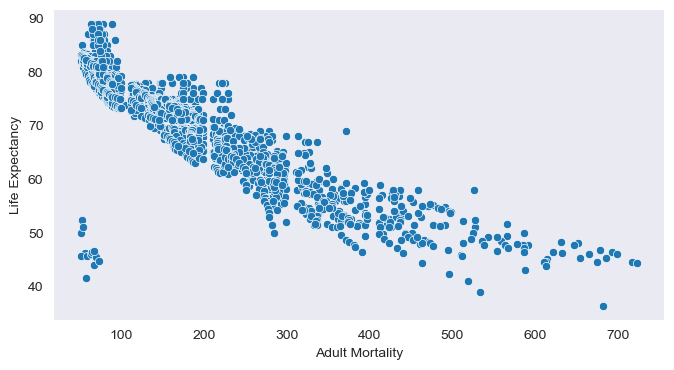

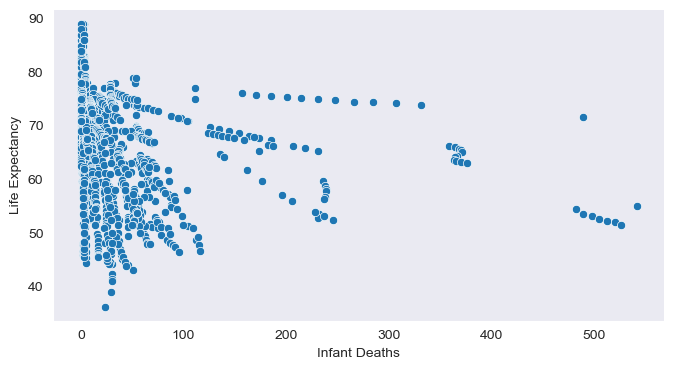

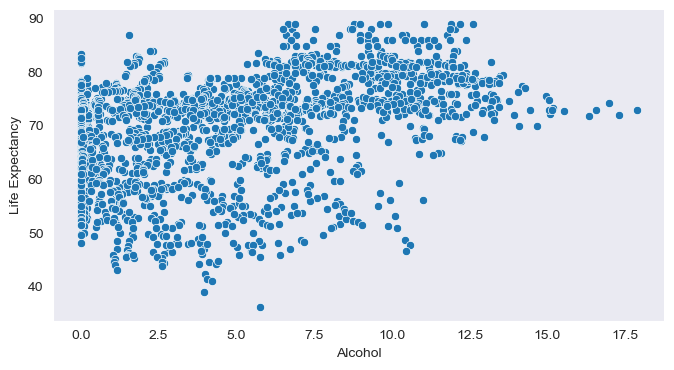

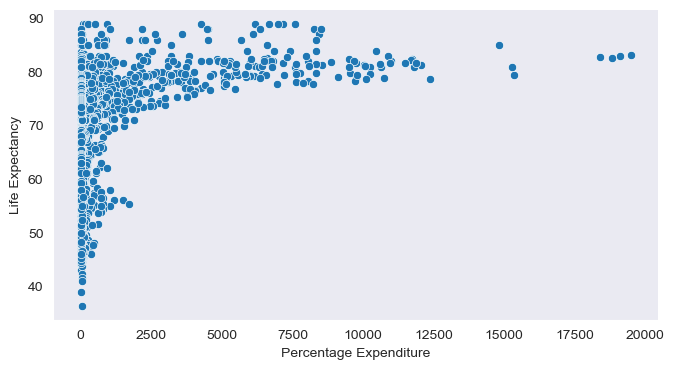

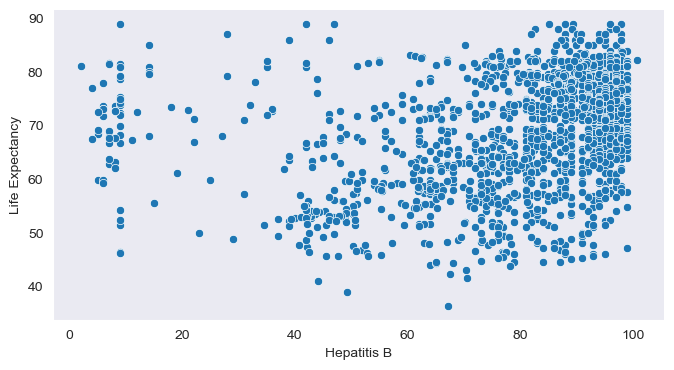

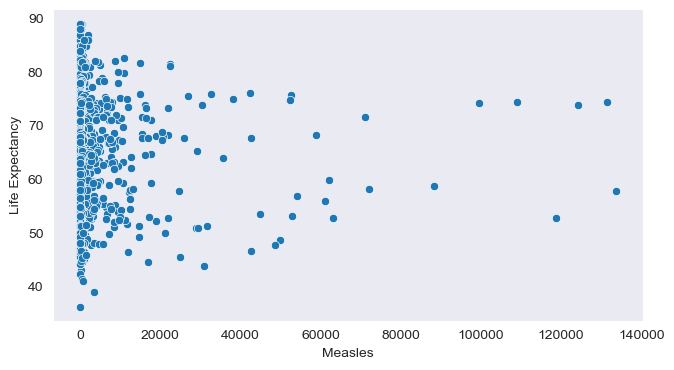

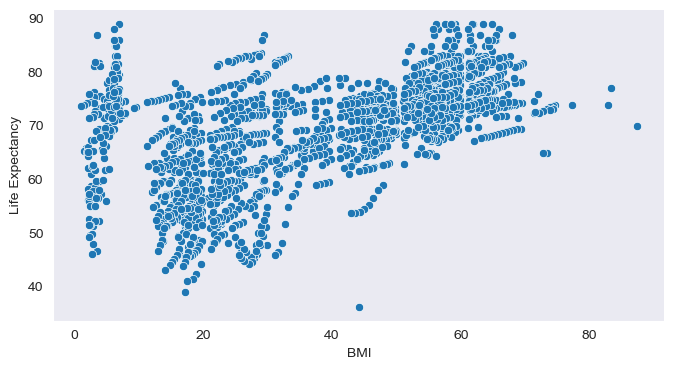

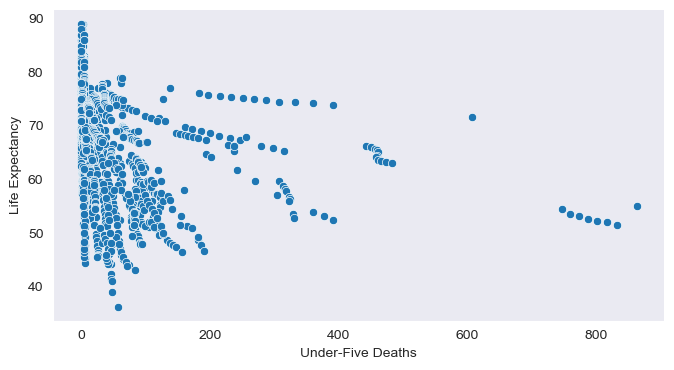

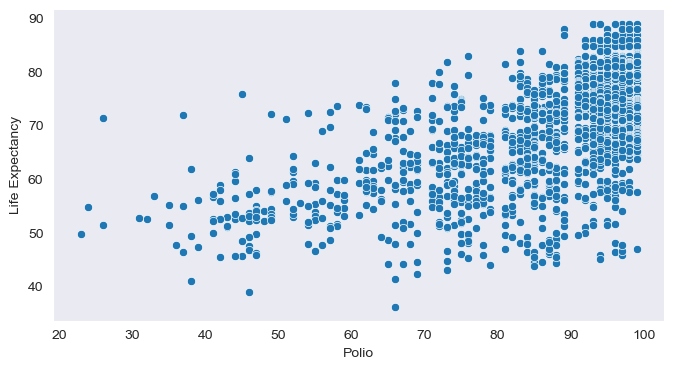

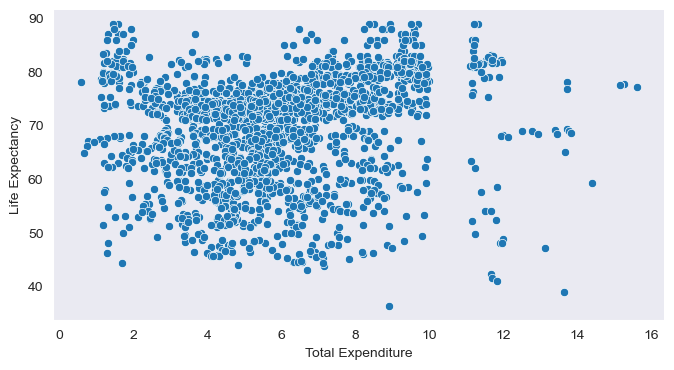

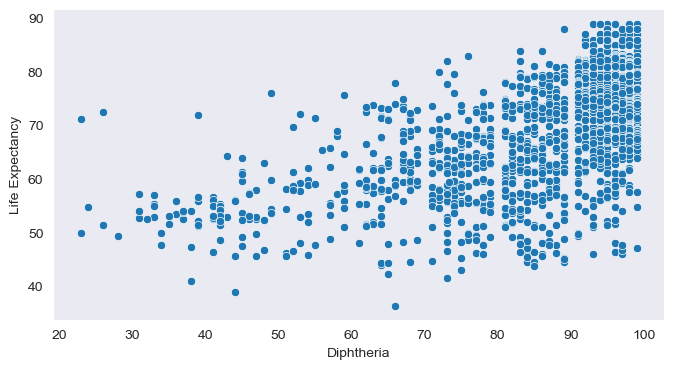

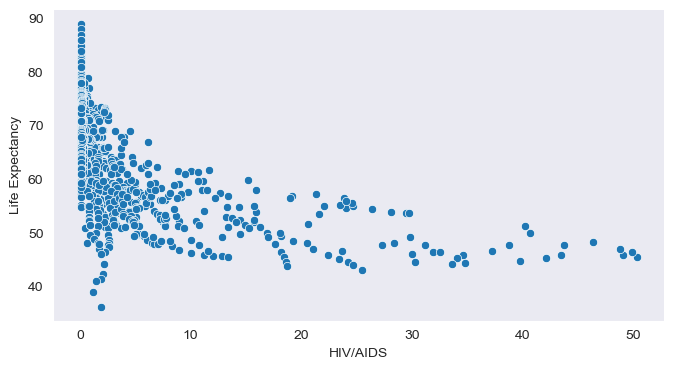

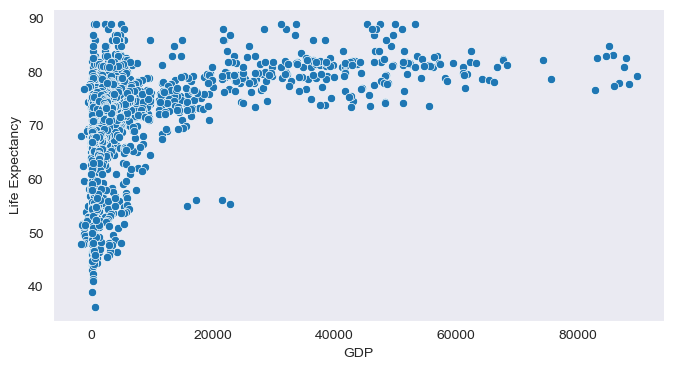

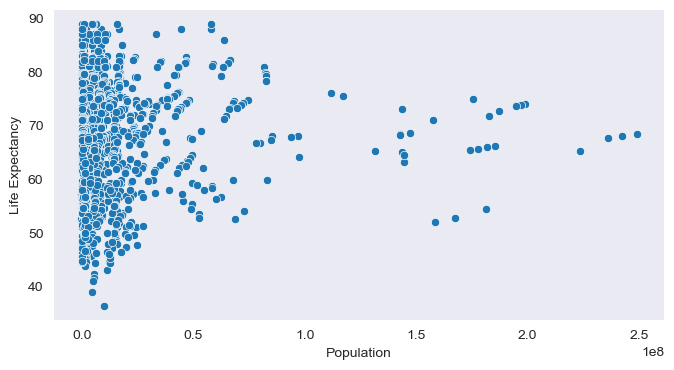

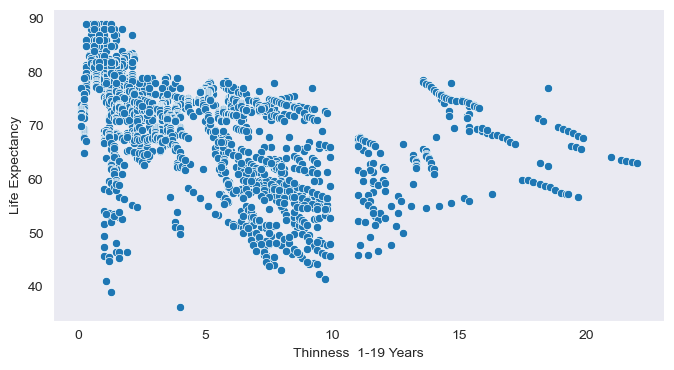

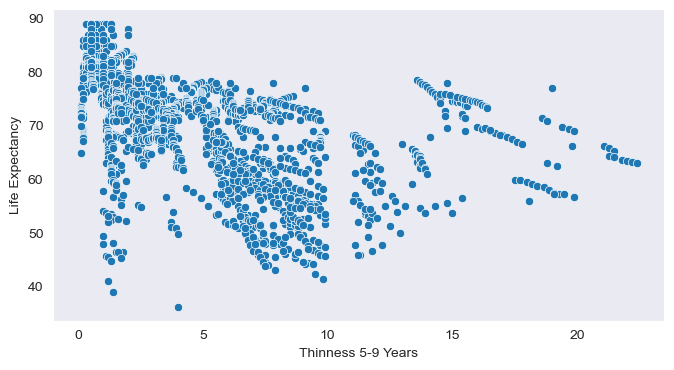

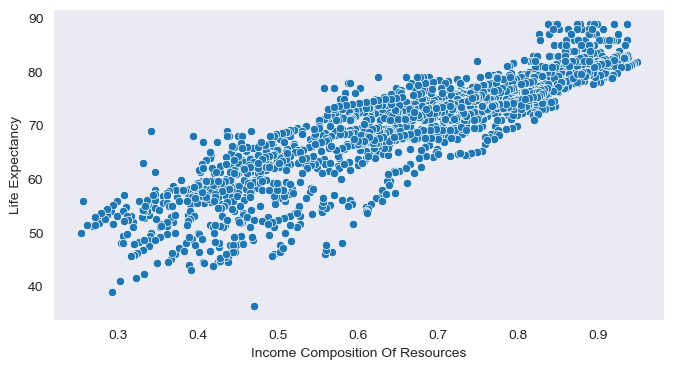

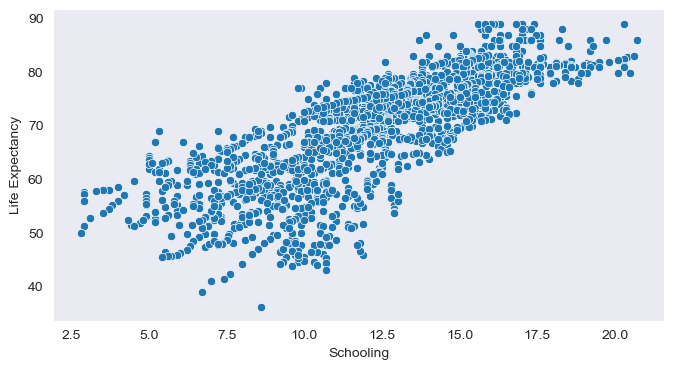

In [7]:
# DROP OUTLIER SAMPLES
# Post-Hoc NOTE: I also decided to chase after the outliers after getting bad R2 scores. This turned out to be EXTREMELY worth it.
# I didn't use the ".index then .drop" filtering approach because this (painstaking conditional reassignment) is easier to follow.
data = data[data['Adult Mortality'] >= 50]
data = data[data['Alcohol'] >= 0]
data = data[data['Polio'] >= 20]
data = data[data['Diphtheria'] >= 20]
data = data[data['GDP'] <= 100000]
data = data[data['Thinness  1-19 Years'] < 25]
data = data[data['Thinness 5-9 Years'] < 25]
data = data[data['Income Composition Of Resources'] > 0.2]
data = data[data['Schooling'] > 1]

# GENERATE SCATTERPLOTS FOR EDUCATED GUESSES OF WHAT COLUMNS TO USE
for label in data.columns:
    if label == 'Life Expectancy': continue
    sns.set_style('dark')
    sns.relplot(x=label, y='Life Expectancy', data=data, height=3.8, aspect=1.8, kind='scatter')

In [8]:
print("Number of entries after removal of outliers:", data.shape[0])

Number of entries after removal of outliers: 2092


**Preliminary Findings (Naive)**
1. **Adult Mortality** has a strong negative correlation with Life Expectancy. ("Life Expectancy" here appears to be "Life Expectancy at Birth"). Some outliers are present, wherein low adult mortality has translated to low life expectancy; low adult mortality to high life expectancy is more understandable. Let us retain this.
2. **Infant Deaths** have a very weak negative correlation with Life Expectancy. Understandably, less infant deaths could translate to stronger healthcare, hence higher life expectancy, as can be seen in the plot where low infant deaths gave us high life expectancy. I think that we should retain this feature, at least for our first run.
3. **Alcohol use** has a weak positive correlation with Life Expectancy, with life expectancy plateuing at an "optimal" level of (assumed) alcohol consumption around 7.5 to 12.5. Let us retain this intriguing feature, which could imply that higher alcohol use does not necessarily mean shorter life spans especially when paired with good healthcare and a strong economy.
4. **Percentage Expenditure** (which I'm assuming is on health) has a moderate positive correlation with Life Expectancy especially if we truncate the outliers of very high percentage expenditures. The plot indicates that good public healthcare goes a long way, even if it's not the luxury kind of healthcare in highly developed countries. Let us retain this.
5. **Prevalence of Hepatitis B** (or cases, ditto thereafter) have a weak positive correlation with Life Expectancy. I think this could be explained by the fact that Hepatitis B is very prevalent, with 296 million active cases in 2019 and many more presenting evidence of infection (carrier or not). Let us retain this. I guess the more people there are alive, the greater the cases of these highly contagious diseases.
6. **Prevalence of Measles** doesn't have a significant relationship with Life Expectancy. I think this could be explained by Measle's greater impact on child mortality. Because this would ambiguously skew our results, let us drop this.
7. **BMI** has a positive correlation with Life Expectancy. Let us retain this.
8. **Under-Five Deaths** doesn't have a significant correlation with Life Expectancy. Let us drop this as this does not have a useful relationship to the target.
9. **Prevalence of Polio** has a weak positive correlation with Life Expectancy. Let us retain this intriguing feature.
10. **Total (Government) Expenditure** has a weak positive correlation with Life Expectancy. Let us retain this.
11. **Prevalence of Diptheria** has a weak positive correlation with Life Expectancy. Let us retain this intriguing feature.
12. **Prevalence of HIV/AIDS** has a weak negative correlation with Life Expectancy. Let us retain this.
13. **GDP** has a moderate positive correlation with Life Expectancy. Let us retain this.
14. **Population** doesn't have a significant relationship with Life Expectancy. Let us drop this.
15. **Thinness (1-19 Years)** has a moderate negative correlation with Life Expectancy. Let us retain this.
16. **Thinness (5-9 Years)** has a moderate negative correlation with Life Expectancy. Let us retain this.
17. **Income Composition of Resources** has a strong positive correlation with Life Expectancy. Let us definitely keep this.
18. **Schooling** has a strong positive correlation with Life Expectancy. Let us keep this.

Considering these linear correlations, we can also say that Linear Regression would be appropriate for this dataset.
**Post-Hoc NOTE:** After seeing my initial results and the regression lines for each feature vs target, I decided to drop more features to possibly improve the R2 score.
Additional Features dropped include 'Infant Deaths'.
**Post-Post-Hoc NOTE:** After seeing my R2 score worsen after dropping more features, I decided to pivot my approach to imputation and removal of outliers.

In [9]:
# DROP COLUMNS WITH NO SIGNIFICANT RELATIONSHIP WITH TARGET
# With the above findings in mind, let us drop the features that doesn't have a useful relationship with our target.
data.drop(['Under-Five Deaths'], axis=1, inplace=True)
data.head()     # Verify if correct columns have been dropped or retained.

# Post-hoc NOTE: We decided to retain all columns after witnessing our R2 score drop after dropping some of them, even with our "educated" guess.
# Post-Post-Hoc NOTE: Actually, dropping 'Under-Five Deaths' improved my score a bit.

Life Expectancy  Adult Mortality  Infant Deaths  Alcohol  \
1             59.9            271.0           64.0     0.01   
2             59.9            268.0           66.0     0.01   
3             59.5            272.0           69.0     0.01   
4             59.2            275.0           71.0     0.01   
5             58.8            279.0           74.0     0.01   

   Percentage Expenditure  Hepatitis B  Measles   BMI  Polio  \
1               73.523582         62.0    492.0  18.6   58.0   
2               73.219243         64.0    430.0  18.1   62.0   
3               78.184215         67.0   2787.0  17.6   67.0   
4                7.097109         68.0   3013.0  17.2   68.0   
5               79.679367         66.0   1989.0  16.7   66.0   

   Total Expenditure  Diphtheria  HIV/AIDS         GDP  Population  \
1               8.18        62.0       0.1  612.696514    327582.0   
2               8.13        64.0       0.1  631.744976  31731688.0   
3               8.52        67.0       0.1  669.959000   3696958.0   
4               7.87        68.0       0.1   63.537231   2978599.0   
5               9.20        66.0       0.1  553.328940   2883167.0   

   Thinness  1-19 Years  Thinness 5-9 Years  Income Composition Of Resources  \
1                  17.5                17.5                            0.476   
2                  17.7                17.7                            0.470   
3                  17.9                18.0                            0.463   
4                  18.2                18.2                            0.454   
5                  18.4                18.4                            0.448   

   Schooling  
1       10.0  
2        9.9  
3        9.8  
4        9.5  
5        9.2

In [10]:
# PREPARE FEATURES AND TARGET DATA
X = data.iloc[:,1:]   # feature matrix
y = data.iloc[:,0]  # target vector
X.head()

Adult Mortality  Infant Deaths  Alcohol  Percentage Expenditure  \
1            271.0           64.0     0.01               73.523582   
2            268.0           66.0     0.01               73.219243   
3            272.0           69.0     0.01               78.184215   
4            275.0           71.0     0.01                7.097109   
5            279.0           74.0     0.01               79.679367   

   Hepatitis B  Measles   BMI  Polio  Total Expenditure  Diphtheria  HIV/AIDS  \
1         62.0    492.0  18.6   58.0               8.18        62.0       0.1   
2         64.0    430.0  18.1   62.0               8.13        64.0       0.1   
3         67.0   2787.0  17.6   67.0               8.52        67.0       0.1   
4         68.0   3013.0  17.2   68.0               7.87        68.0       0.1   
5         66.0   1989.0  16.7   66.0               9.20        66.0       0.1   

          GDP  Population  Thinness  1-19 Years  Thinness 5-9 Years  \
1  612.696514    327582.0                  17.5                17.5   
2  631.744976  31731688.0                  17.7                17.7   
3  669.959000   3696958.0                  17.9                18.0   
4   63.537231   2978599.0                  18.2                18.2   
5  553.328940   2883167.0                  18.4                18.4   

   Income Composition Of Resources  Schooling  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5  
5                            0.448        9.2

In [11]:
y.head()

1    59.9
2    59.9
3    59.5
4    59.2
5    58.8
Name: Life Expectancy, dtype: float64

In [12]:
# PREPARE TRAIN AND TEST DATA
# NOTE: random_state = 1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

print("X_train.shape:\t", X_train.shape)
print("X_test.shape:\t", X_test.shape)
print("y_train.shape:\t", y_train.shape)
print("y_test.shape:\t", y_test.shape)

X_train.shape:	 (1464, 17)
X_test.shape:	 (628, 17)
y_train.shape:	 (1464,)
y_test.shape:	 (628,)


### Perform regression on the dataset.
The goal is to use regression on the dataset with the best result you can.

Import the LinearRegression class from the linear_model to train the model. Instantiate an object of the class named regressor. The regressor object is also called an estimator. An estimator is any object that fits a model based on some training data and is capable of inferring some properties on new data. All estimators implement a fit method.
The fit method takes the training data as the argument. We use this method to estimate some parameters of a model. For instance, we have passed in the X_train and the y_train – the independent and dependent variables. The model learns the correlations between the predictor and target variables.

In [13]:
# TODO: Write your code here. (5 points)
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

**Getting the coefficient/slope and the intercept.**
Now that we have fitted the model, we can check the slope and the intercept of the simple linear fit.

In [14]:
print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)

Coefficients: [-3.17097347e-02 -3.68681769e-03 -5.16691776e-02  2.79491073e-04
 -1.66982055e-02  5.58483260e-07 -6.98232973e-03  4.86862371e-03
  1.20371164e-01  6.04412602e-02 -2.01716474e-01 -4.64941680e-05
  3.82440754e-10  5.56302791e-03 -1.60084453e-02  3.28843432e+01
 -1.56466499e-01]
Intercept: 52.0627494452284


**Plotting the Regression Plots with 95% (ci=95) confidence interval.**
Note that these plots are very helpful when we're trying to decide what columns to use.
We can go back and revise our feature matrix using the knowledge we get here.

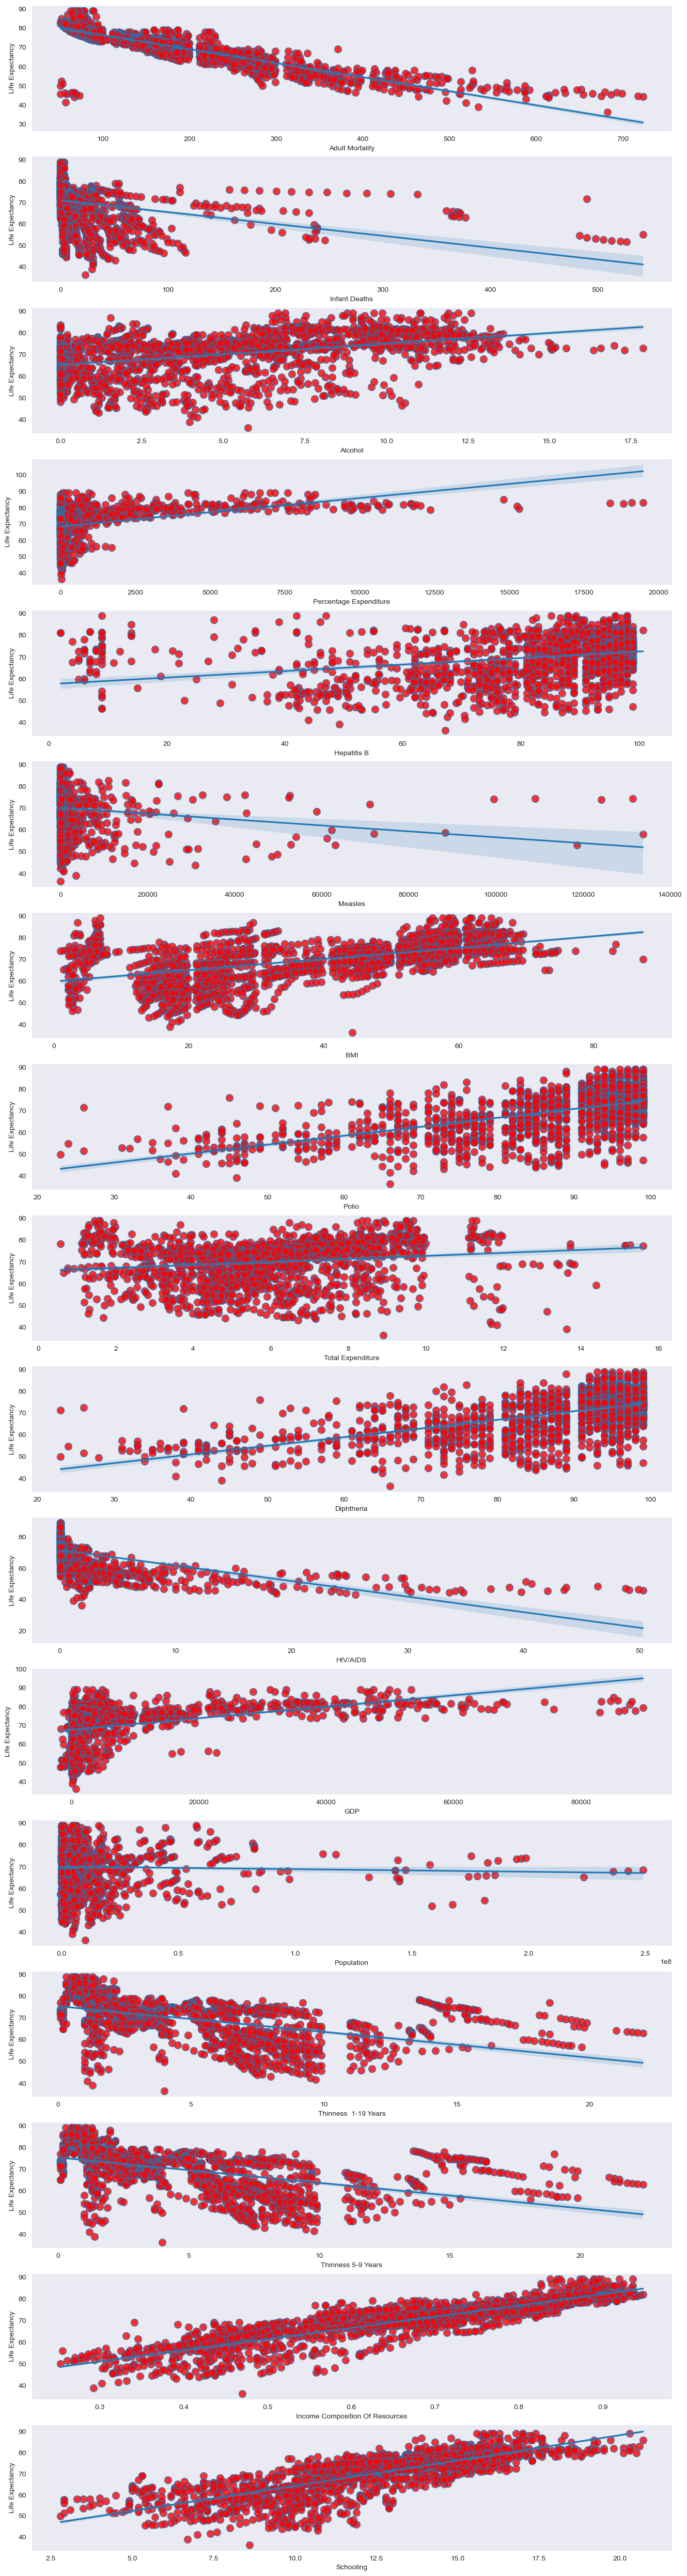

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=len(data.columns)-1, ncols=1, figsize=(16,64))

i = 0
for label in data.columns:
    if label == "Life Expectancy": continue
    sns.regplot(x=label, y='Life Expectancy', data=data, ci=95, scatter_kws={'s':100, 'facecolor':'red'}, ax=axs[i])
    i += 1

### Show results.

At this point, the model is now trained and ready to predict the output of new observations. Remember, we split our dataset into train and test sets. We will provide test sets to the model and check its performance.

In [16]:
# TODO: Write your code here. (5 points)
y_pred = regressor.predict(X_test)
y_pred

array([80.93589756, 76.91097821, 50.11222678, 51.82854054, 45.44608752,
       61.68855533, 70.95685654, 71.09899857, 82.71273822, 64.63656084,
       63.65164786, 67.70622184, 80.20834713, 69.04500622, 76.9004791 ,
       80.78378606, 80.23040432, 69.4919085 , 68.47437325, 69.31890333,
       71.65751935, 81.22173615, 73.32353832, 51.75649281, 49.06897794,
       68.37708652, 71.27360603, 68.06986951, 77.58248459, 62.1800511 ,
       71.35795033, 79.06256744, 65.82631747, 59.99993954, 82.04878152,
       75.89469175, 64.33774907, 81.30979307, 79.97414412, 72.91047177,
       78.7866465 , 50.02534178, 81.63392305, 53.31793433, 74.27726392,
       79.70729492, 57.88908234, 78.14719486, 49.85527697, 79.12788217,
       70.53179283, 80.39109614, 81.80834374, 52.85467968, 77.36233144,
       70.30285397, 74.30819642, 77.8381452 , 76.97475536, 81.78507213,
       79.789546  , 43.21900197, 75.24130222, 54.52824321, 85.79376183,
       73.72879607, 73.96389276, 71.45752963, 70.10294805, 69.45

In [17]:
comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
comparison_df

Actual  Predicted
1276    80.0  80.935898
1740    74.2  76.910978
2496    51.4  50.112227
892     56.0  51.828541
2729    46.6  45.446088
...      ...        ...
2881    74.9  71.372038
758     61.3  61.445344
1423    66.7  67.904189
118     81.7  81.978270
2075    77.5  76.370366

[628 rows x 2 columns]

**Checking the residuals:**

In [18]:
residuals = y_test - y_pred
residuals

1276   -0.935898
1740   -2.710978
2496    1.287773
892     4.171459
2729    1.153912
          ...   
2881    3.527962
758    -0.145344
1423   -1.204189
118    -0.278270
2075    1.129634
Name: Life Expectancy, Length: 628, dtype: float64

Comparing the test data and the predicted values with a scatter plot:

Text(0, 0.5, 'Predictions')

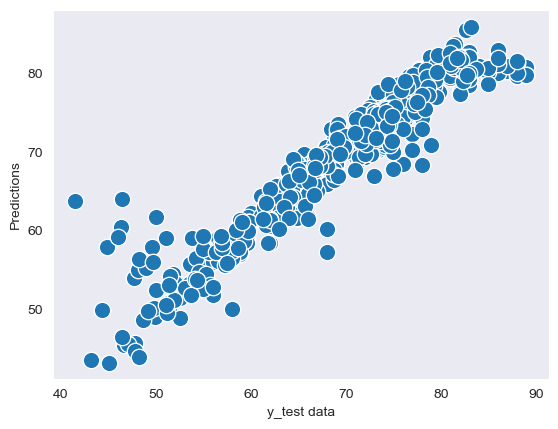

In [19]:
import matplotlib.pyplot as plt
#sns.scatterplot(x=y_test, y = y_pred, ci=None, s=140)
sns.scatterplot(x=y_test, y = y_pred, s=140)
plt.xlabel('y_test data')
plt.ylabel('Predictions')

The values seem to align linearly, which shows that the model is acceptable.

**Mean Absolute Error (MAE)** calculates the absolute difference between the actual and predicted values. We get the sum of all the prediction errors and divide them by the total number of data points.

In [20]:
from sklearn.metrics import mean_absolute_error
print('MAE:', mean_absolute_error(y_test,y_pred))

MAE: 1.9763465008137633


**Mean Squared Error (MSE):** This is the most used metric. It finds the squared difference between actual and predicted values. We get the sum of the square of all prediction errors and divide it by the number of data points.

In [21]:
from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_test,y_pred))

MSE 8.501632263178534


**Root Mean Squared Error (RMSE)** is the square root of MSE. Since MSE is calculated by the square of error, the square root brings it back to the same level of prediction error.

In [22]:
import numpy as np
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE 2.9157558648107926


**R Squared (R2):** R2 is also called the coefficient of determination or goodness of fit score regression function. It measures how much irregularity in the dependent variable the model can explain. The R2 value is between 0 and 1, and a bigger value shows a better fit between prediction and actual value.

In [23]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("R2 Score:", r2)      # We use this as our main metric

R2 Score: 0.9052645846306924


The model has a pretty good score, meaning it was sufficiently precise and accurate in predicting the life expectancy.

### Conclusions
**Assuming random_state=1 for train_test_split():**
1. We can conclude that the simple linear model we built works fine in predicting the life expectancy based on all the features (minus 'Under-Five Deaths') since the errors were relatively low and the R2 score was high (but not too high that we might be overfitting the data).
2. Following the idea that we could drop uninformative features, my first approach was to drop the features that I eyeballed from their scatterplots as not having a significant relationship with the target vector. However, dropping those features worsened my R2 score, which is quite unexpected, so I decided to retain them instead. **Post-Post-Hoc NOTE:** Actually, dropping 'Under-Five Deaths' improved my score a bit.
3. I figured that by recklessly applying .dropna(), I'm actually dropping 44% of the samples from the dataset, and those precious samples could have better informed our regressor. So I decided to use multivariate imputation to instead fill (estimate) those values. The result I got from this actually scored worse (likely due to the subsequent appearance of more outliers in our dataset), until...
4. I stamped out many outliers (especially those negative values in 'Alcohol'), and this turned out to be the *answer*.

From this exercise, I came to better understand Sir Carlo's notion that preprocessing is actually more than half the battle in data science, and is a very important step in ensuring the sanity and the accuracy of both our data and data interpretations.